<a href="https://colab.research.google.com/github/lechemrc/DS-Unit-2-Applied-Modeling/blob/master/Rob_LeCheminant_DS_Sprint_Challenge_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_

# Applied Modeling Sprint Challenge: Predict Chicago food inspections 🍔

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to install packages in Colab:

In [1]:
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

#### Run this cell to load the data:

In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

In [3]:
print(train.shape)
train.head()

(51916, 17)


Inspection ID  ... Fail
0        2088270  ...    1
1         555268  ...    0
2        1751394  ...    0
3        1763905  ...    0
4         453326  ...    0

[5 rows x 17 columns]

### Important Imports

In [4]:
# libraries and math functions
import pandas as pd
import numpy as np
import pandas_profiling
from scipy.io import arff # for loading .arff file
from scipy.stats import randint, uniform
import random

# imports for pipeline and regression
import category_encoders as ce
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import validation_curve
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.utils.multiclass import unique_labels
from ipywidgets import interact, fixed
from xgboost import XGBRegressor, XGBClassifier
from pdpbox import pdp
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import eli5
from eli5.sklearn import PermutationImportance
import shap

# plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

Using TensorFlow backend.


### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:

- Permutation Importances
- Partial Dependence Plot, 1 feature isolation
- Partial Dependence Plot, 2 features interaction
- Shapley Values

_To earn a score of 3 for this part, make all four of these visualization types._

## Part 1: Preprocessing

> You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

### Code used to create data wrangling function (below)

#### Checking null values

In [5]:
train.isna().sum()

Inspection ID         0
DBA Name              0
AKA Name            623
License #             5
Facility Type       224
Risk                 12
Address               0
City                 53
State                10
Zip                  26
Inspection Date       0
Inspection Type       1
Violations         9655
Latitude            198
Longitude           198
Location            198
Fail                  0
dtype: int64

#### Longitude and Latitude

In [6]:
# Wondering about the possibility of filling long and lat with something like geopy
# will return to this
train[train['Latitude'].isna() == True]

Inspection ID                             DBA Name  ... Location  Fail
4             453326                              MORRILL  ...      NaN     0
89           2050181             FINKI ELEMENTARY ACADEMY  ...      NaN     0
262          1150344                     Morgan Park(H/S)  ...      NaN     0
278           579776      Peace & Ed. Coalition(SINCLAIR)  ...      NaN     0
432          2060059                       DEETER COOKIES  ...      NaN     0
700          1579073                                Dewey  ...      NaN     1
749          1955241      Peace & Ed. Coalition(SINCLAIR)  ...      NaN     0
935           233637                            Sauganash  ...      NaN     0
1067         1386157                  DANIEL WILLIAM HALE  ...      NaN     0
1107          347310                     SUPREME CATERING  ...      NaN     0
1450           67947                GUGGENHEIM ELEMENTARY  ...      NaN     0
1586         1955357                               SUBWAY  ...      NaN     0
1862         1401842                  DANIEL WILLIAM HALE  ...      NaN     0
2389         1300730                              Beasley  ...      NaN     0
2493         1578427                             Porkchop  ...      NaN     0
2704         2104764                                 LARA  ...      NaN     0
2717         1386530                           PARK MANOR  ...      NaN     0
2757          529244                                 LARA  ...      NaN     0
2789         1305295                              MORRILL  ...      NaN     1
2814         1435160             FINKI ELEMENTARY ACADEMY  ...      NaN     0
3087         1307451                        DUNKIN DONUTS  ...      NaN     0
3212         1990142                         IZAKAYA YUME  ...      NaN     0
3588         1300367                      CUHL FOODS, LLC  ...      NaN     0
3935          657313                                DUMAS  ...      NaN     0
4116         2167124                  DANIEL WILLIAM HALE  ...      NaN     0
4794           74471                  DANIEL WILLIAM HALE  ...      NaN     0
4912          234137              DOLLAR TREE STORE, INC.  ...      NaN     1
4953         1234424  DIVINE INSPIRATIONS GOURMET SERVICE  ...      NaN     0
5027          347308                     SUPREME CATERING  ...      NaN     0
5930         1096400     BERGSTEIN'S NY DELICATESSEN, LLC  ...      NaN     0
...              ...                                  ...  ...      ...   ...
42872         670838                 O'HARE GASLIGHT CLUB  ...      NaN     0
43104        1234734            DE COLORES ICE CREAM INC.  ...      NaN     0
43725         250459                   ALBARAKA ICE CREAM  ...      NaN     0
43836        1975450                    CAMINO A LA SALUD  ...      NaN     0
43996        2232359                           PARK MANOR  ...      NaN     0
44928         537645              Carver Military Academy  ...      NaN     0
45337         462304                    THE LOGAN THEATRE  ...      NaN     0
45886         531220                               SUBWAY  ...      NaN     0
46058         250878      Peace & Ed. Coalition(SINCLAIR)  ...      NaN     0
46553        2176826                         Carson (Old)  ...      NaN     1
46648        1989537                     Morgan Park(H/S)  ...      NaN     0
46822        2240360                       WADSWORTH ELEM  ...      NaN     0
47096        2051025        K INTERCONTINENTAL RESTAURANT  ...      NaN     0
47254        1657234             KRISPY SEAFOOD & CHICKEN  ...      NaN     0
47291        1369223                 CUPCAKES FOR COURAGE  ...      NaN     0
47450        1307421              SHARKS FISH AND CHICKEN  ...      NaN     0
47610        1566699          KOMAL WINE AND LIQUORS INC.  ...      NaN     0
48151        1424973                       BEGYLE BREWING  ...      NaN     0
48400        2177149                 O'HARE GASLIGHT CLUB  ...      NaN     0
48415         920433   CHICAG

In [7]:
px.scatter(train, x='Longitude', y='Latitude', color='Fail')

#### Feature engineering: violation length

with the idea that the length of 'Violations' means more violations, I am engineering a features to show that length to help in the prediction

In [8]:
int(train['Violations'].str.len().max()), int(train['Violations'].str.len().min())

(8965, 56)

In [9]:
train['Violation_length'] = train['Violations'].str.len()
train['Violation_length'].head(10)

0    2385.0
1    2872.0
2     234.0
3     299.0
4    1383.0
5    2195.0
6     748.0
7     198.0
8    1126.0
9    1338.0
Name: Violation_length, dtype: float64

#### Feature Engineering: Facility Type

In [10]:
frequencies = train['Facility Type'].value_counts()
condition = frequencies <= 10
mask = frequencies[condition].index
mask_dict = dict.fromkeys(mask, 'other')
train['Facility Type'] = train['Facility Type'].replace(mask_dict)
train['Facility Type'].value_counts()


Restaurant                         34264
Grocery Store                       6904
School                              3876
Bakery                               846
Daycare (2 - 6 Years)                830
Children's Services Facility         802
other                                768
Daycare Above and Under 2 Years      656
Long Term Care                       394
Catering                             304
Mobile Food Dispenser                280
Liquor                               261
Daycare Combo 1586                   227
Wholesale                            203
Golden Diner                         162
Mobile Food Preparer                 159
Hospital                             141
TAVERN                                88
Shared Kitchen User (Long Term)       69
Daycare (Under 2 Years)               65
Special Event                         62
GAS STATION                           33
KIOSK                                 33
BANQUET HALL                          30
Shelter         

#### Feature Engineering: Inspection Type

In [11]:
train['Inspection Type'].value_counts()

Canvass                                   24170
License                                    7825
Canvass Re-Inspection                      6346
Complaint                                  4948
License Re-Inspection                      3002
Complaint Re-Inspection                    2241
Short Form Complaint                       2103
License-Task Force                          214
Suspected Food Poisoning                    207
Consultation                                189
Tag Removal                                 146
Out of Business                             109
Task Force Liquor 1475                       92
Recent Inspection                            66
Suspected Food Poisoning Re-inspection       58
Complaint-Fire                               51
Short Form Fire-Complaint                    36
Special Events (Festivals)                   21
No Entry                                     21
Package Liquor 1474                          16
Complaint-Fire Re-inspection            

In [12]:
frequencies = train['Inspection Type'].value_counts()
condition = frequencies <= 10
mask = frequencies[condition].index
mask_dict = dict.fromkeys(mask, 'other')
train['Inspection Type'] = train['Inspection Type'].replace(mask_dict)
train['Inspection Type'].value_counts()

Canvass                                   24170
License                                    7825
Canvass Re-Inspection                      6346
Complaint                                  4948
License Re-Inspection                      3002
Complaint Re-Inspection                    2241
Short Form Complaint                       2103
License-Task Force                          214
Suspected Food Poisoning                    207
Consultation                                189
Tag Removal                                 146
Out of Business                             109
Task Force Liquor 1475                       92
Recent Inspection                            66
Suspected Food Poisoning Re-inspection       58
Complaint-Fire                               51
other                                        40
Short Form Fire-Complaint                    36
Special Events (Festivals)                   21
No Entry                                     21
Package Liquor 1474                     

#### Feature Engineering: Datetime things!

In [0]:
train['Inspection Date'] = pd.to_datetime(train['Inspection Date'], infer_datetime_format=True)
train['Year'] = train['Inspection Date'].dt.year
train['Month'] = train['Inspection Date'].dt.month


In [14]:
# interestingly, month seems to dictate some variance in failures
fail = train.groupby('Month')['Fail'].value_counts()
fail

Month  Fail
1      0       3197
       1       1116
2      0       2928
       1       1031
3      0       3624
       1       1190
4      0       3356
       1       1152
5      0       3743
       1       1209
6      0       3615
       1       1241
7      0       2588
       1       1026
8      0       3149
       1       1237
9      0       3354
       1       1234
10     0       3389
       1       1203
11     0       2925
       1        947
12     0       2622
       1        840
Name: Fail, dtype: int64

### Data Wrangling


In [0]:
# reloading data here to make it easier if session crashes to run all
train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

In [16]:
train.columns

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date',
       'Inspection Type', 'Violations', 'Latitude', 'Longitude', 'Location',
       'Fail'],
      dtype='object')

In [0]:
def data_wrangling(df):
  ''' Wrangles data for train and test sets prior to val split'''

  df = df.copy()

  # Creating Violation Length column (assumption is that > len = more violations)
  df['Violation_length'] = df['Violations'].str.len().astype(float)

  # Datetime column creation
  df['Inspection Date'] = pd.to_datetime(
      df['Inspection Date'], infer_datetime_format=True)
  df['Year'] = df['Inspection Date'].dt.year
  df['Month'] = df['Inspection Date'].dt.month

  # Changing the Facility Type column values to 'other' if there are less
  # than 10 instances in the df
  frequencies = df['Facility Type'].value_counts()
  condition = frequencies <= 10
  mask = frequencies[condition].index
  mask_dict = dict.fromkeys(mask, 'other')
  df['Facility Type'] = df['Facility Type'].replace(mask_dict)

  # Changing the Inspection Type column values to 'other' if there are less
  # than 10 instances in the df
  frequencies = df['Inspection Type'].value_counts()
  condition = frequencies <= 10
  mask = frequencies[condition].index
  mask_dict = dict.fromkeys(mask, 'other')
  df['Inspection Type'] = df['Inspection Type'].replace(mask_dict) 

  return df

In [0]:
def data_wrangling_drop(df):
  ''' Wrangles data for train and test sets prior to val split
  Includes columns that are dropped for accuracy'''

  df = df.copy()

  # Creating Violation Length column (assumption is that > len = more violations)
  df['Violation_length'] = df['Violations'].str.len().astype(float)

  # Datetime column creation
  df['Inspection Date'] = pd.to_datetime(
      df['Inspection Date'], infer_datetime_format=True)
  df['Year'] = df['Inspection Date'].dt.year
  df['Month'] = df['Inspection Date'].dt.month

  # Changing the Facility Type column values to 'other' if there are less
  # than 10 instances in the df
  frequencies = df['Facility Type'].value_counts()
  condition = frequencies <= 10
  mask = frequencies[condition].index
  mask_dict = dict.fromkeys(mask, 'other')
  df['Facility Type'] = df['Facility Type'].replace(mask_dict)

  # Changing the Inspection Type column values to 'other' if there are less
  # than 10 instances in the df
  frequencies = df['Inspection Type'].value_counts()
  condition = frequencies <= 10
  mask = frequencies[condition].index
  mask_dict = dict.fromkeys(mask, 'other')
  df['Inspection Type'] = df['Inspection Type'].replace(mask_dict) 

  # Dropping columns that may muddy or overfit the prediction
  df = df.drop(['Inspection ID', 'DBA Name', 'AKA Name', 
                'License #', 'State', 'City', 'Location',
                'Address', 'Zip', 'Inspection Date', 'Violations'], axis=1)

  return df

In [19]:
train = data_wrangling_drop(train)
test = data_wrangling_drop(test)

train.shape, test.shape

((51916, 9), (17306, 9))

### Setting up features
Prepping for Train / Test / Val split

In [20]:
target = 'Fail'
train_features = train.drop(columns=[target])
numeric_features = train_features.select_dtypes(include='number').columns.tolist()
categorical_features = train_features.select_dtypes(exclude='number').columns.tolist()

features = numeric_features + categorical_features
features

['Latitude',
 'Longitude',
 'Violation_length',
 'Year',
 'Month',
 'Facility Type',
 'Risk',
 'Inspection Type']

### Train / Test / Val Split

In [21]:
# Train / Val split 
train, val = train_test_split(train, test_size=len(test),  
                              stratify=train[target], random_state=42)

train.shape, val.shape, test.shape

((34610, 9), (17306, 9), (17306, 9))

In [22]:
# Arrange data into X features matrix and y target vector
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((34610, 8), (34610,), (17306, 8), (17306,), (17306, 8), (17306,))

## Part 2: Modeling

> **Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.
>
> Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

#### Random Forest Classifier with Ordinal Encoder

Note: This gives an accuracy of 81.2%

In [23]:
random_forest = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

random_forest.fit(X_train, y_train)
print('Validation Accuracy:', random_forest.score(X_val, y_val), 
      '\nTest Accuracy:', random_forest.score(X_test, y_test))

Validation Accuracy: 0.8505142725066451 
Test Accuracy: 0.8482029353981279


##### Permutation Importances

In [24]:
# Using eli5 to find permutation importances

# transforming data for permuter
transformers = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.fit_transform(X_val)

# setting model
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

# setting permuter to permutation importance
permuter = PermutationImportance(
    model, 
    scoring='accuracy',
    n_iter=3,
    random_state=42
)

# fitting the data
permuter.fit(X_val_transformed, y_val)
feature_names = X_val.columns.tolist()

eli5.show_weights(
    permuter,
    top=None,
    feature_names = feature_names
)

##### ROC AUC SCORE

In [25]:
# ROC Score

y_pred_proba = random_forest.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_proba)

0.8824194961680099

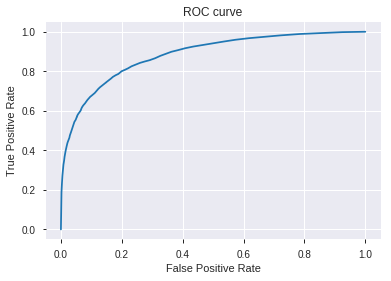

In [26]:
# Plot ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val==1, y_pred_proba)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

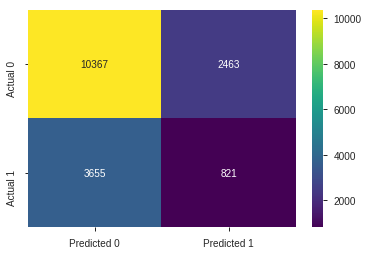

In [27]:
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

y_pred = random_forest.predict(X_test)
plot_confusion_matrix(y_val, y_pred);

#### Random Forest Classifier with OneHot Encoder (not using... this crashes session)

In [0]:
# random_forest = make_pipeline(
#     ce.OneHotEncoder(use_cat_names=True),
#     SimpleImputer(strategy='median'),
#     RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
# )

# random_forest.fit(X_train, y_train)
# print('Validation Accuracy:', random_forest.score(X_val, y_val))

#### XGBoost Classifier with Ordinal Encoding

Note: This gives an accuracy of 83.1%

In [29]:
xgboost = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

xgboost.fit(X_train, y_train)
print('Validation Accuracy:', xgboost.score(X_val, y_val), 
      '\nTest Accuracy:', xgboost.score(X_test, y_test))

Validation Accuracy: 0.8451404137293425 
Test Accuracy: 0.8443314457413614


## Part 3: Visualization

> Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:
>
> - Permutation Importances
> - Partial Dependence Plot, 1 feature isolation
> - Partial Dependence Plot, 2 features interaction
> - Shapley Values

### Using XGBoost Model for the following visualizations:

#### Model

In [30]:
xgboost = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

xgboost.fit(X_train, y_train)
print('Validation Accuracy:', xgboost.score(X_val, y_val), 
      '\nTest Accuracy:', xgboost.score(X_test, y_test))

Validation Accuracy: 0.8451404137293425 
Test Accuracy: 0.8443314457413614


#### Permutation Importances

In [31]:
# Using eli5 to find permutation importances

# transforming data for permuter
transformers = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.fit_transform(X_val)

# setting model
model = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

# setting permuter to permutation importance
permuter = PermutationImportance(
    model, 
    scoring='accuracy',
    n_iter=3,
    random_state=42
)

# fitting the data
permuter.fit(X_val_transformed, y_val)
feature_names = X_val.columns.tolist()

eli5.show_weights(
    permuter,
    top=None,
    feature_names = feature_names
)

#### Maunal Permuation Importances

In [32]:
score_with = random_forest.score(X_val, y_val)
X_val_permuted = X_val.copy()

# Looping through all features to test importance
for feature in X_train.columns:
  X_val_permuted[feature] = np.random.permutation(X_val[feature])

  score_permuted = random_forest.score(X_val_permuted, y_val)
  perm_imp = score_with - score_permuted

  print (f'Validation Accuracy with {feature}: {score_with}')
  print (f'Validation Accuracy with {feature} permuted: {score_permuted}')
  print (f'Permutation Importance: {score_with - score_permuted}')
  print('------------------------------------------------------\n')

Validation Accuracy with Latitude: 0.8505142725066451
Validation Accuracy with Latitude permuted: 0.8428868600485381
Permutation Importance: 0.007627412458107052
------------------------------------------------------

Validation Accuracy with Longitude: 0.8505142725066451
Validation Accuracy with Longitude permuted: 0.8401132555183174
Permutation Importance: 0.010401016988327738
------------------------------------------------------

Validation Accuracy with Violation_length: 0.8505142725066451
Validation Accuracy with Violation_length permuted: 0.6631803998613198
Permutation Importance: 0.1873338726453253
------------------------------------------------------

Validation Accuracy with Year: 0.8505142725066451
Validation Accuracy with Year permuted: 0.6616780307407836
Permutation Importance: 0.18883624176586156
------------------------------------------------------

Validation Accuracy with Month: 0.8505142725066451
Validation Accuracy with Month permuted: 0.6598289610539697
Permutatio

#### ROC AUC SCORE

In [33]:
# ROC Score

y_pred_proba = xgboost.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_proba)

0.874928692177976

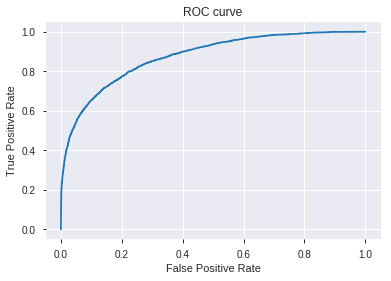

In [34]:
# Plot ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val==1, y_pred_proba)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

#### Confusion Matrix

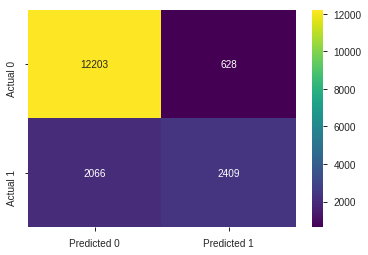

In [35]:
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')


y_pred = xgboost.predict(X_test)
plot_confusion_matrix(y_test, y_pred);

#### Distplot of Pass / Fail

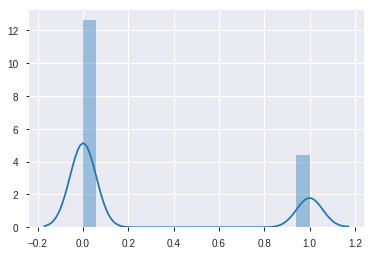

In [36]:
# Visualizing the split between pass and fail
encoder = ce.OrdinalEncoder()
y_train_encoded = encoder.fit_transform(y_train)
sns.distplot(y_train_encoded);

### Partial Dependency Plots

#### Partial Dependency Plot for 'Risk'

In [37]:
target = 'Fail'
features = train.columns.drop([target])

X = train[features]
y = train[target]

# Use Ordinal Encoder, outside of a pipeline
encoder = ce.OrdinalEncoder()
X_encoded = encoder.fit_transform(X)

model = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_encoded, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

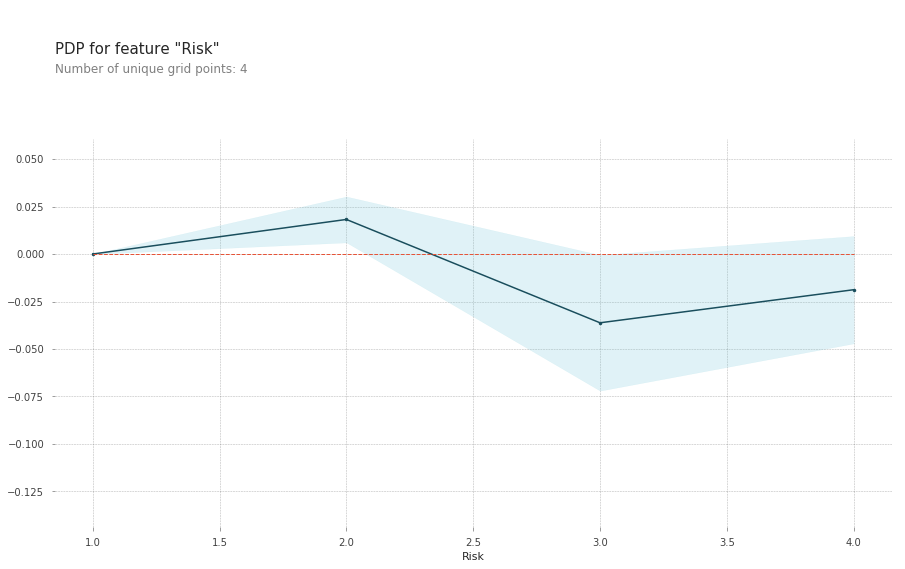

In [38]:
from pdpbox import pdp

feature = 'Risk'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

#### PDP for two features

In [39]:
train.columns

Index(['Facility Type', 'Risk', 'Inspection Type', 'Latitude', 'Longitude',
       'Fail', 'Violation_length', 'Year', 'Month'],
      dtype='object')

In [40]:
train['Risk'].isna().sum()

8

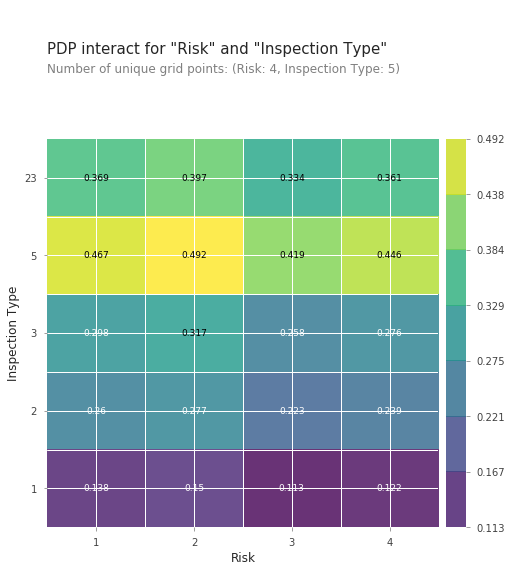

In [41]:
features = ['Risk', 'Inspection Type']

interaction = pdp_interact(
    model=model, 
    dataset=X_encoded, 
    model_features=X_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

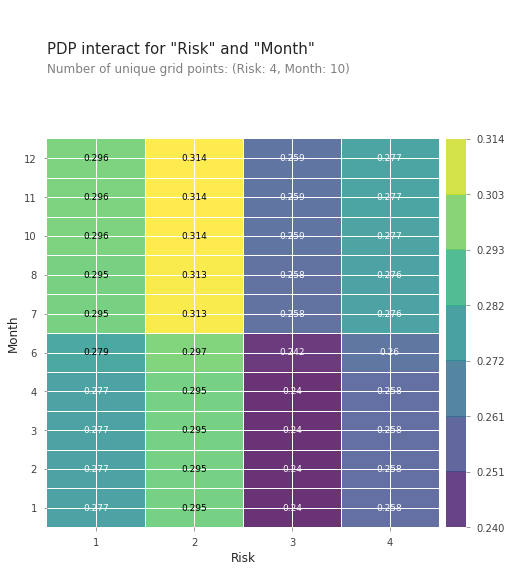

In [42]:
features = ['Risk', 'Month']

interaction = pdp_interact(
    model=model, 
    dataset=X_encoded, 
    model_features=X_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

#### PDP for 'Violation_length'

 not working, unfortunately

In [43]:
feature = 'Violation_length'

isolated = pdp_isolate(
    model = xgboost,
    dataset = X_val,
    model_features = X_val.columns,
    feature = feature,
    num_grid_points=80
)

pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=100)
plt.xlim(0, 5000);

ValueError: ignored

### Detailed Explanations of Predictions with Shapley Values

In [44]:
processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=100, n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

row = X_test.iloc[[10]]

explainer = shap.TreeExplainer(model)
row_process = processor.transform(row)
shap_values = explainer.shap_values(row_process)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)

[0]	validation_0-auc:0.827898	validation_1-auc:0.821275
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.832423	validation_1-auc:0.826966
[2]	validation_0-auc:0.83495	validation_1-auc:0.829527
[3]	validation_0-auc:0.836155	validation_1-auc:0.830658
[4]	validation_0-auc:0.836426	validation_1-auc:0.830987
[5]	validation_0-auc:0.836539	validation_1-auc:0.83094
[6]	validation_0-auc:0.841408	validation_1-auc:0.835227
[7]	validation_0-auc:0.845064	validation_1-auc:0.837005
[8]	validation_0-auc:0.846006	validation_1-auc:0.838112
[9]	validation_0-auc:0.846376	validation_1-auc:0.838366
[10]	validation_0-auc:0.846424	validation_1-auc:0.838388
[11]	validation_0-auc:0.853379	validation_1-auc:0.847213
[12]	validation_0-auc:0.853932	validation_1-auc:0.847468
[13]	validation_0-auc:0.854169	validation_1-auc:0.847687
[14]	validation_0-auc:0.85424	validation_1-auc:0.847703
[

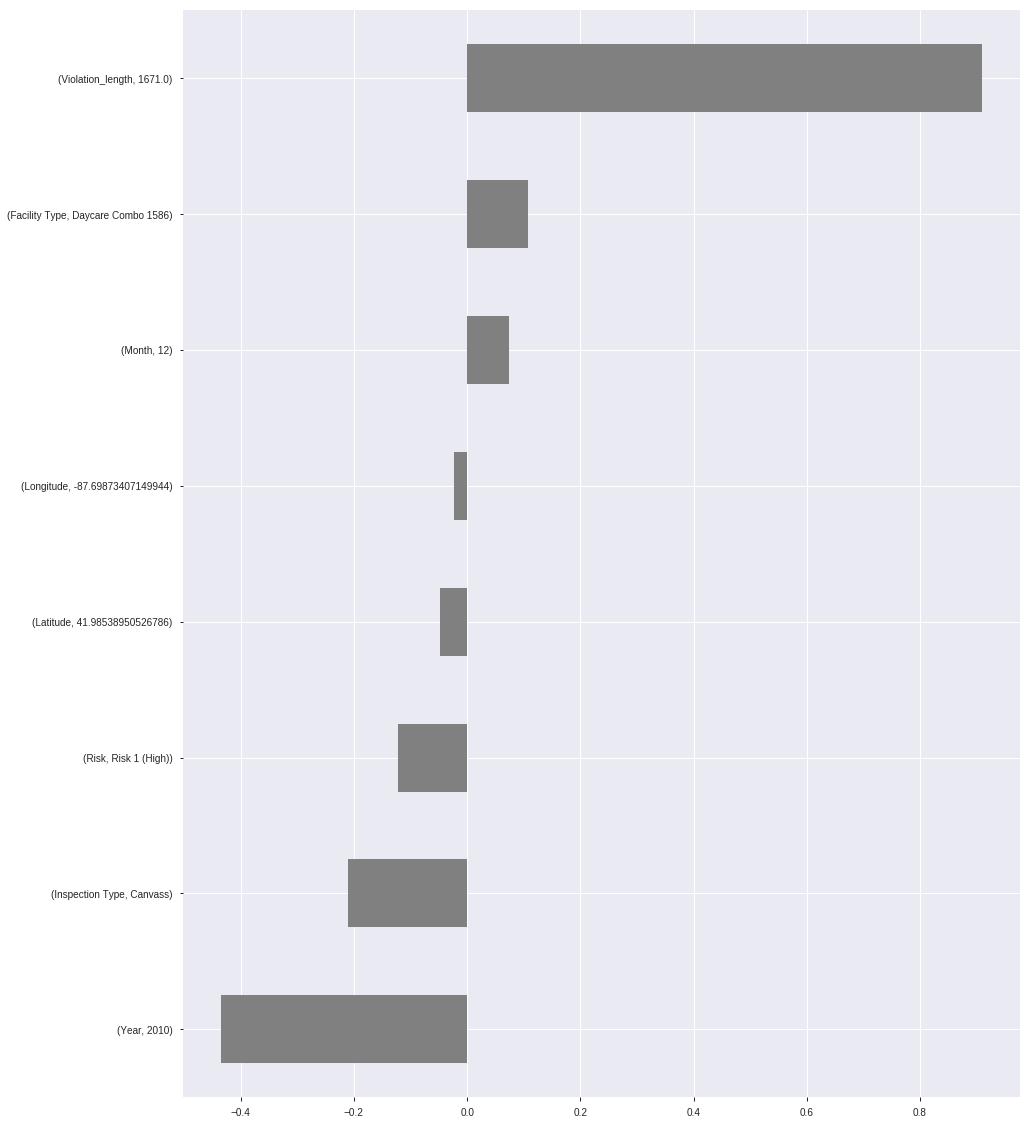

In [45]:
feature_names = row.columns
feature_values = row.values[0]
shaps = pd.Series(shap_values[0], zip(feature_names,feature_values))
shaps.sort_values().plot.barh(color='grey', figsize=(15,20));

In [0]:
def explain(row_number):
  ''' detailed explanation of the shapley values and what is happening
  with the data'''

  positive_class = 'Fail'
  positive_class_index = 1
    
  # Get & process the data for the row
  row = X_test.iloc[[row_number]]
  row_processed = processor.transform(row)
    
  # Make predictions (includes predicted probability)
  pred = model.predict(row_processed)[0]
  pred_proba = model.predict_proba(row_processed)[0, positive_class_index]
  pred_proba *= 100
  if pred != positive_class:
    pred_proba = 100 - pred_proba
    
  # Show prediction & probability
  print(f'The model predicts the failure rate of a healthcode inspection is {pred}, with {pred_proba:.0f}% probability.')
    

  # Get shapley additive explanations
  shap_values = explainer.shap_values(row_processed)
    
  # Get top 3 "pros & cons"
  feature_names = row.columns
  feature_values = row.values[0]
  shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))
  pros = shaps.sort_values(ascending=False)[:4].index
  cons = shaps.sort_values(ascending=True)[:4].index
   
  # Show top 4 reasons for prediction
  print('\n')
  print('Top 4 reasons for prediction:')
  evidence = pros if pred == positive_class else cons
  for i, info in enumerate(evidence, start=1):
      feature_name, feature_value = info
      print(f'{i}. {feature_name} is {feature_value}.')
    
  # Show top 1 counter-argument against prediction
  print('\n')
  print('Top counter-argument against prediction:')
  evidence = cons if pred == positive_class else pros
  feature_name, feature_value = evidence[0] 
  print(f'- {feature_name} is {feature_value}.')
    
    
  # Show Shapley Values Force Plot
  shap.initjs()
  return shap.force_plot(
      base_value=explainer.expected_value, 
      shap_values=shap_values, 
      features=row
  )
    
def multi_explain(samples):
  for i in random.sample(range(len(X_test)), 10):
    explain(i)

#### Multiple Shapley Values

In [49]:
# I am unsure of why the plot is not displaying in this, but it gives lots of 
# great information on a random sampling of values from the data and their 
# predictive probablity given the model 

multi_explain(10)

The model predicts the failure rate of a healthcode inspection is 0, with 95% probability.


Top 4 reasons for prediction:
1. Violation_length is 340.0.
2. Inspection Type is Canvass.
3. Facility Type is Restaurant.
4. Year is 2015.


Top counter-argument against prediction:
- Risk is Risk 2 (Medium).


The model predicts the failure rate of a healthcode inspection is 0, with 84% probability.


Top 4 reasons for prediction:
1. Violation_length is 915.0.
2. Inspection Type is Canvass.
3. Longitude is -87.77547129108139.
4. Latitude is 41.94567362501872.


Top counter-argument against prediction:
- Risk is Risk 3 (Low).


The model predicts the failure rate of a healthcode inspection is 0, with 91% probability.


Top 4 reasons for prediction:
1. Violation_length is 187.0.
2. Risk is Risk 1 (High).
3. Month is 1.
4. Year is 2016.


Top counter-argument against prediction:
- Inspection Type is License.


The model predicts the failure rate of a healthcode inspection is 0, with 87% probability.


Top 4 reasons for prediction:
1. Violation_length is 957.0.
2. Inspection Type is Canvass.
3. Risk is Risk 1 (High).
4. Latitude is 41.968072672415474.


Top counter-argument against prediction:
- Year is 2013.


The model predicts the failure rate of a healthcode inspection is 1, with 43% probability.


Top 4 reasons for prediction:
1. Risk is Risk 1 (High).
2. Month is 2.
3. Facility Type is Restaurant.
4. Year is 2014.


Top counter-argument against prediction:
- Inspection Type is License.


The model predicts the failure rate of a healthcode inspection is 1, with 36% probability.


Top 4 reasons for prediction:
1. Latitude is 41.9568024778031.
2. Facility Type is Restaurant.
3. Longitude is -87.74725863483394.
4. Risk is Risk 2 (Medium).


Top counter-argument against prediction:
- Violation_length is 1205.0.


The model predicts the failure rate of a healthcode inspection is 0, with 87% probability.


Top 4 reasons for prediction:
1. Year is 2011.
2. Inspection Type is Canvass.
3. Risk is Risk 1 (High).
4. Month is 3.


Top counter-argument against prediction:
- Longitude is -87.63663755997726.


The model predicts the failure rate of a healthcode inspection is 0, with 84% probability.


Top 4 reasons for prediction:
1. Violation_length is 520.0.
2. Facility Type is Grocery Store.
3. Longitude is -87.58625101198423.
4. Latitude is 41.7573962131662.


Top counter-argument against prediction:
- Risk is Risk 3 (Low).


The model predicts the failure rate of a healthcode inspection is 1, with 25% probability.


Top 4 reasons for prediction:
1. Facility Type is Restaurant.
2. Longitude is -87.60573012143782.
3. Month is 8.
4. Latitude is 41.77799819601639.


Top counter-argument against prediction:
- Violation_length is 1833.0.


The model predicts the failure rate of a healthcode inspection is 0, with 95% probability.


Top 4 reasons for prediction:
1. Violation_length is nan.
2. Facility Type is Shared Kitchen User (Long Term).
3. Inspection Type is Canvass.
4. Risk is Risk 1 (High).


Top counter-argument against prediction:
- Longitude is -87.67264808913937.
